### LID using Wav2Vec 2.0
**Wav2Vec 2.0** is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.  Soon after the superior performance of Wav2Vec2 was demonstrated on the English ASR dataset LibriSpeech, *Facebook AI* presented XLSR-Wav2Vec2 (click [here](https://arxiv.org/abs/2006.13979)). XLSR stands for *cross-lingual  speech representations* and refers to XLSR-Wav2Vec2`s ability to learn speech representations that are useful across multiple languages.

Similar to Wav2Vec2, XLSR-Wav2Vec2 learns powerful speech representations from hundreds of thousands of hours of speech in more than 50 languages of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/xlsr_wav2vec2.png)

The authors show for the first time that massively pretraining an ASR model on cross-lingual unlabeled speech data, followed by language-specific fine-tuning on very little labeled data achieves state-of-the-art results. See Table 1-5 of the official [paper](https://arxiv.org/pdf/2006.13979.pdf).
<hr>

In [1]:
## loading important libraries
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import librosa
import IPython.display as ipd
from SilenceRemover import *
import matplotlib.pyplot as plt
from VAD_Audio import test

In [3]:
# loading the autdio dataset from the directory
directory  = "/Users/yash/Desktop/MTP-2k23-24/TTS_data"
data = []
# for path in tqdm(os.listdir(directory)):
#     # now eplore the inner folder ,
#     #  path is actually the audio language
#     pathHere = os.path.join(directory, path);
#     count = 0;
#     if not path.startswith('.'):
#         for subFoldlers in os.listdir(pathHere):
#             if not subFoldlers.startswith('.'):
#                 pathHere2 = os.path.join(pathHere,subFoldlers);
#                 ## Now expploring all the available audio files inside 
#                 ## and if not corrupted storing then in dataframe 
#                 for audioSamples in os.listdir(pathHere2):
#                     ## extracto all req info
#                     name = audioSamples.split(".")[0]
#                     finalPath = os.path.join(pathHere2, audioSamples);
#                     try:
#                         # There are some broken files
#                         s = torchaudio.load(finalPath)
#                         data.append({
#                             "name": name,
#                             "path": finalPath,
#                             "language": path,
#                         });
#                         count = count +1;
#                     except Exception as e:
#                         print(str(path), e)
#                         pass
#         print(f'Total {count} samples loaded of {path} langueage dataset')
for path in tqdm(os.listdir(directory)):
    # now eplore the inner folder ,
    #  path is actually the audio language
    pathHere = os.path.join(directory, path);
    count = 0;
    if not path.startswith('.'):
        for subFoldlers in os.listdir(pathHere):
            if not subFoldlers.startswith('.'):
                finalPath = os.path.join(pathHere,subFoldlers);
                name = subFoldlers.split(".")[0]
                try:
                    # There are some broken files
                    s, sr = torchaudio.load(finalPath)
                    data.append({
                        "name": name,
                        "path": finalPath,
                        "sampling_rate": sr,
                        "language": path,
                    });
                    count = count +1;
                except Exception as e:
                    print(str(path), e)
                    pass
        print(f'Total {count} samples loaded of {path} langueage dataset')

  9%|▉         | 1/11 [00:01<00:12,  1.23s/it]

Total 200 samples loaded of eng langueage dataset


 18%|█▊        | 2/11 [00:02<00:08,  1.01it/s]

Total 100 samples loaded of tel langueage dataset


 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

Total 100 samples loaded of mar langueage dataset


 36%|███▋      | 4/11 [00:02<00:04,  1.71it/s]

Total 100 samples loaded of odi langueage dataset


 45%|████▌     | 5/11 [00:03<00:02,  2.07it/s]

Total 100 samples loaded of asm langueage dataset


 55%|█████▍    | 6/11 [00:03<00:02,  1.98it/s]

Total 100 samples loaded of guj langueage dataset


 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

Total 100 samples loaded of hin langueage dataset


 73%|███████▎  | 8/11 [00:05<00:02,  1.37it/s]

Total 100 samples loaded of tam langueage dataset


 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

Total 100 samples loaded of kan langueage dataset


 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

Total 100 samples loaded of mal langueage dataset


100%|██████████| 11/11 [00:06<00:00,  1.60it/s]

Total 100 samples loaded of ben langueage dataset


In [4]:
print("Total length of the Dataset: ", len(data))

Total length of the Dataset:  1200


In [5]:
## now lets form a dataframe from the data array
df = pd.DataFrame(data)
df.head()

,name,path,sampling_rate,language
0,train_malayalamfemale_02337,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
1,train_kannadafullfemale_05405,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
2,train_marathimale_04522,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
3,train_telugufemale_00074,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
4,train_malayalamfemale_02727,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng


In [6]:
# Filter broken and non-existed paths

print(f"Step 0: {len(df)}")

df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["path"])
df = df.drop("status", axis='columns')
print(f"Step 1: {len(df)}")

df = df.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

Step 0: 1200
Step 1: 1200


,name,path,sampling_rate,language
0,train_telugumale_02711,/Users/yash/Desktop/MTP-2k23-24/TTS_data/tel/t...,48000,tel
1,train_hindifullfemale_04232,/Users/yash/Desktop/MTP-2k23-24/TTS_data/hin/t...,48000,hin
2,train_gujaratinewfemale_00436,/Users/yash/Desktop/MTP-2k23-24/TTS_data/guj/t...,48000,guj
3,train_malayalammale_04299,/Users/yash/Desktop/MTP-2k23-24/TTS_data/mal/t...,48000,mal
4,train_assamesemale_01866,/Users/yash/Desktop/MTP-2k23-24/TTS_data/asm/t...,48000,asm


In [7]:
## ecpplore dataset stats
print("Labels: ", df["language"].unique())
print()
df.groupby("language").count()[["path"]]

Labels:  ['tel' 'hin' 'guj' 'mal' 'asm' 'ben' 'mar' 'kan' 'odi' 'eng' 'tam']



,path
language,
asm,100
ben,100
eng,200
guj,100
hin,100
kan,100
mal,100
mar,100
odi,100


Let's display some random sample of the dataset and run it a couple of times to get a feeling for the audio and the emotional label.

ID Location: 581
      Label: asm

Original sampling Rate:  48000


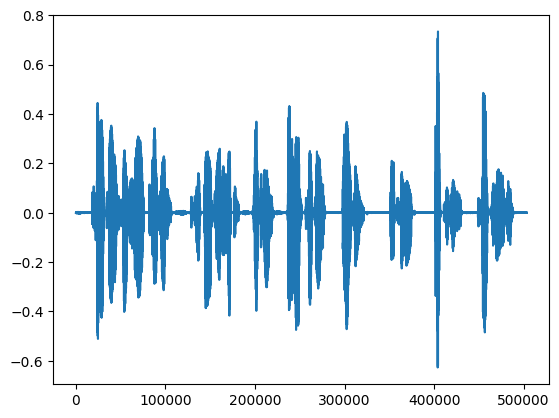

In [8]:
# np.random.seed(33)
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["path"]
label = sample["language"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
plt.plot(speech)
print("Original sampling Rate: ",sr)
# Resample the audio signal to a target sampling rate of 16,000 Hz
speech = librosa.resample(speech, orig_sr=sr, target_sr=8000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=8000)


Audio After Silence Removal


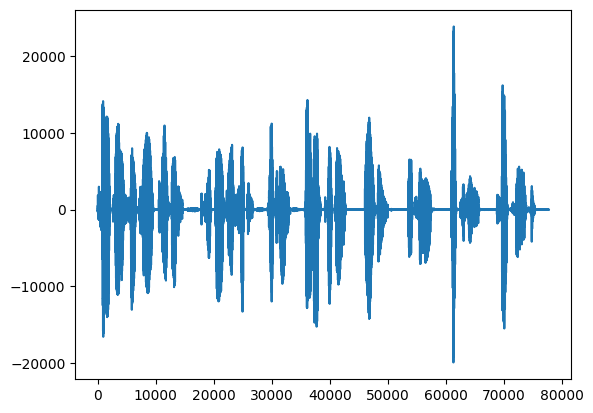

In [9]:
## After removing the silence from the file
print("Audio After Silence Removal")
silencedAudio = RemoveSilence(df.iloc[idx]['path'],"hello.wav")
plt.plot(silencedAudio)
## playibg the silence audio
ipd.Audio(data=silencedAudio, autoplay=True, rate=8000)


In [10]:
# ## After removing the silence from the file
# print("Audio After Energy-VAD Silence Removal")
# silencedAudio = test(df.iloc[idx]['path'])
# plt.plot(silencedAudio)
# ## playibg the silence audio
# ipd.Audio(data=silencedAudio, autoplay=True, rate=16000)


In [11]:
speech

array([-0.00069101, -0.00067595,  0.0003472 , ..., -0.00067844,
       -0.00082065,  0.        ], dtype=float32)

For training purposes, we need to split data into train test sets; in this specific example, we break with a `20%` rate for the test set.

In [ ]:
save_path = "CSV_Data"
if save_path not in os.listdir():
    os.mkdir(save_path)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["language"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", index=False)
test_df.to_csv(f"{save_path}/test.csv", index=False)


print(train_df.shape)
print(test_df.shape)

In [18]:
# function to check and if directory does not exists create one
def CreateIfNot(parent, path):
    if path not in os.listdir(parent):
        os.mkdir(os.path.join(parent,path))
        print("created")
    return os.path.join(parent,path)

In [ ]:
# loading the autdio dataset from the directory
directory  = "/Users/yash/Desktop/MTP-2k23-24/TTS_data"
root = "/Users/yash/Desktop/MTP-2k23-24"
# FolderName
folderName = "TTS_data_SilenceRemovedData"
# check if directory exist
newDirectory = CreateIfNot(root, folderName)
newDirectory = "/Users/yash/Desktop/MTP-2k23-24/TTS_data_SilenceRemovedData"
data = []

for path in tqdm(os.listdir(directory)):
    # now eplore the inner folder ,
    #  path is actually the audio language
    pathHere = os.path.join(directory, path);
    # create new path 
    NewPathHere = CreateIfNot(newDirectory, path);
    count = 0;
    if not path.startswith('.'):
        for audioFile in os.listdir(pathHere):
            if not audioFile.startswith('.'):
                ## Now expploring all the available audio files inside 
                ## and if not corrupted storing then in dataframe 
                ## extracto all req info
                # name = audioSamples.split(".")[0]
                finalPath = os.path.join(pathHere,audioFile)
                destinationPath = os.path.join(NewPathHere,audioFile)
                try:
                    # Try if there are some broken files
                    speech, sr = torchaudio.load(finalPath)
                    silencedAudio = RemoveSilence(finalPath, destinationPath)
                    count = count +1;
                except Exception as e:
                    print(str(path), e)
        print(f'Total {count} samples loaded and saved after silence removal of {path} langueage dataset')

In [ ]:
# # loading the autdio dataset from the directory
# directory  = "/Users/yash/Desktop/MTP-2k23-24/Sample_Data"
# root = "/Users/yash/Desktop/MTP-2k23-24"
# newDirectory = "SilenceRemovedData"
# # check if directory exist
# CreateIfNot(root, newDirectory)
# newDirectory = "/Users/yash/Desktop/MTP-2k23-24/SilenceRemovedData"
# data = []
# for path in tqdm(os.listdir(directory)):
#     # now eplore the inner folder ,
#     #  path is actually the audio language
#     pathHere = os.path.join(directory, path);
#     # create new path 
#     NewPathHere = CreateIfNot(newDirectory, path);
#     print(NewPathHere)
#     count = 0;
#     if not path.startswith('.'):
#         for subFoldlers in os.listdir(pathHere):
#             if not subFoldlers.startswith('.'):
#                 pathHere2 = os.path.join(pathHere,subFoldlers);
#                 NewPathHere2 = CreateIfNot(NewPathHere, subFoldlers);
#                 ## Now expploring all the available audio files inside 
#                 ## and if not corrupted storing then in dataframe 
#                 for audioSamples in os.listdir(pathHere2):
#                     ## extracto all req info
#                     # name = audioSamples.split(".")[0]
#                     finalPath = os.path.join(pathHere2, audioSamples);
#                     AudioPath = os.path.join(NewPathHere2, audioSamples);
#                     try:
#                         # Try if there are some broken files
#                         speech, sr = torchaudio.load(finalPath)
#                         silencedAudio = RemoveSilence(finalPath, AudioPath)
#                         count = count +1;
#                     except Exception as e:
#                         print(str(path), e)
#                         pass
#         print(f'Total {count} samples loaded and saved after silence removal of {path} langueage dataset')